# SOAP analysis

In this notebook we present how we calculated the soap fingerprints
Before executing this notebook, please start and complete the notebook `../create_reference/create_reference.ipynb`

In [5]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from  h5py import File
import pandas as pd
from pandas import DataFrame
import numpy
from MDAnalysis import Universe as mdaUniverse
from matplotlib.pyplot import viridis, get_cmap
import seaborn as sns
from seaborn import clustermap
from HDF5er import saveXYZfromTrajGroup,MDA2HDF5,saveXYZfromTrajGroup
from SOAPify import (saponifyGroup,
                    createReferencesFromTrajectory,
                    mergeReferences,
                    SOAPdistanceNormalized,
                    saveReferences,
                    getReferencesFromDataset,
                    classify
                    )



def patchBoxFromTopology(hdf5TrajFile:str,topologyFile:str):
    u=mdaUniverse(topologyFile,atom_style="id type x y z")
    with File(hdf5TrajFile,"a") as workFile:
        for key in workFile['Trajectories']:
            tgroup=workFile[f'Trajectories/{key}']
            tgroup['Box'][:]=[u.dimensions]*tgroup['Box'].shape[0]

### Settings

Please change `SOAPnJobs` to a reasonable number to not stress too much your system

In [2]:
loadReferences = True
soapReferences = True
SOAPnJobs = 16
SOAPrcut = 6
SOAPnmax = 8
SOAPlmax = 8

## preprocessing the trajectories and calcolating the SOAP fingerprints 
Here we preprocess the trajectories in the hdf5 files and we calculate the SOAP fingerprints by usin dscribe 

In [4]:
if loadReferences:
    Temp=700
    for surf in [110,211,210]:
        for fname in [f"{surf}_T_{Temp}.lammpsdump"]:
            dirname=f"../DPMD/{surf}/{Temp}/"
            u=mdaUniverse(dirname+fname)#, atom_style="id type x y z")
            u.atoms.types = ["Cu"] * len(u.atoms)
            MDA2HDF5(u,f"{surf}.hdf5",fname.split('.')[0], trajChunkSize=1000)
            # we need to patch the box because mda do not load correctpy the triclinic box,
            # at the moment of writing this the issue https://github.com/MDAnalysis/mdanalysis/issues/3383 has been addressed,
            # but if you are using an old vesrion of MDA you will still encounter the problem
            patchBoxFromTopology(f"{surf}.hdf5",f"{surf}.data")
            print(fname, "done")

    loadReferences=False

In [ ]:
if soapReferences:
    for surf in [110,211,210]:
        
        with File(f"{surf}.hdf5","a") as workFile:
            saponifyGroup(
            trajContainers=workFile["Trajectories"],
            SOAPoutContainers=workFile.require_group("SOAP"),
            SOAPOutputChunkDim=1000,
            SOAPnJobs=SOAPnJobs,
            SOAPrcut = SOAPrcut,
            SOAPnmax = SOAPnmax,
            SOAPlmax = SOAPlmax,
        )
    soapReferences=False

## Defining the dictionary
Here we load the dictionary whose component have been preprocessed in `../create_reference/create_reference.ipynb`.
We assign a neam to each memeber, knowing their position
We then caclulate the distance between each dictionary entry

In [9]:
references = {}
with File("../create_reference/references.hdf5", "r") as refFile:
    g = refFile["testReferences"]
    for k in g.keys():
        references[k] = getReferencesFromDataset(g[k])

wholeData = mergeReferences(
    references["111"],
    references["110"],
    references["211"],
    references["210"],
)
dictionaryEntries = ['s$_{(111)}$','ss$_{(111)}$','b$_{(111)}$']+\
    ['s$^{l}$$_{(110)}$','s$^{h}$$_{(110)}$','ss$^{l}$$_{(110)}$','ss$^{h}$$_{(110)}$','b$_{(110)}$']+\
    ['s$^{l}$$_{(211)}$','s$^{m}$$_{(211)}$','s$^{h}$$_{(211)}$','ss$^{l}$$_{(211)}$','ss$^{m}$$_{(211)}$','ss$^{h}$$_{(211)}$','b$_{(211)}$']+\
    ['s$^{l}$$_{(210)}$','s$^{m}$$_{(210)}$','s$^{h}$$_{(210)}$','ss$^{l}$$_{(210)}$','ss$^{m}$$_{(210)}$','ss$^{h}$$_{(210)}$','b$_{(210)}$']   

ndataset = len(wholeData)
#distance calculated in the squareform fashion:
wholeDistances = numpy.zeros((int(ndataset * (ndataset - 1) / 2)))
cpos = 0
for i in range(ndataset):
    for j in range(i + 1, ndataset):
        wholeDistances[cpos] = SOAPdistanceNormalized(
            wholeData.spectra[i], wholeData.spectra[j]
        )
        cpos += 1


We then assign a color to each element of the dictionary and we create a dendrogram from it.
In the dendrogram the colored branches are the ones whose elemneta are at less than 0.01 \[SOAPdist\] between each other

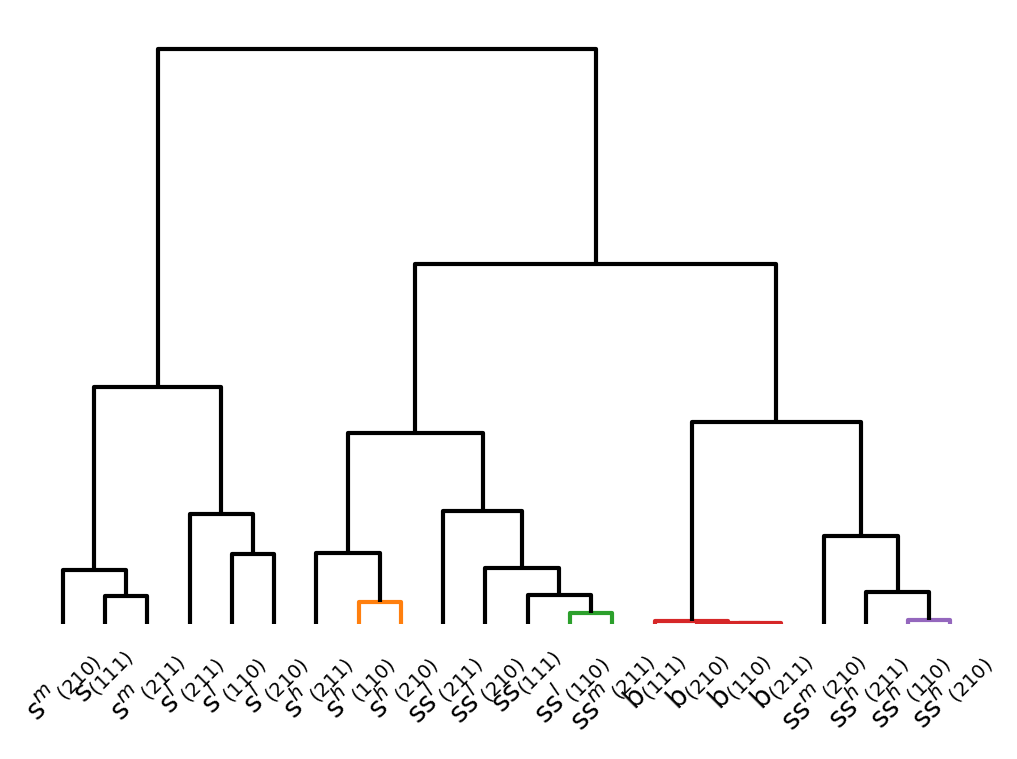

In [32]:
colors = {}
colorbytype = {}
cmaps = {
    "Oranges": get_cmap("Oranges"),
    "Reds": get_cmap("Reds"),
    "Blues": get_cmap("Blues"),
    "Greens": get_cmap("Greens"),
    "GnBu": get_cmap("GnBu"),
    "Greys": get_cmap("Greys"),
    "Purples": get_cmap("Purples"),
}
for k, c in zip(references.keys(), ["Greys", "Reds", "GnBu", "Purples"]):
    colors[k] = [cmaps[c](0.6) for i in range(len(references[k]))]
    colorbytype[k] = []
    for i in range(len(references[k])):
        cc = "Oranges"
        num = 0.6
        if "ss" in references[k].names[i]:
            cc = "Greens"
        elif "s" in references[k].names[i]:
            cc = "Blues"
        
        if "lc" in references[k].names[i]:
            num = 0.4
        elif "hc" in references[k].names[i]:
            num = 0.8
        colorbytype[k].append(cmaps[cc](num))

cr = [] + colors["111"] + colors["110"] + colors["211"] + colors["210"]
cc = (
    []
    + colorbytype["111"]
    + colorbytype["110"]
    + colorbytype["211"]
    + colorbytype["210"]
)

links = linkage(wholeDistances, method="complete")
fig=plt.figure(dpi = 200)
ax=fig.add_subplot(111)
sch.dendrogram(links, color_threshold=0.01,labels=dictionaryEntries,ax=ax,above_threshold_color='k')
sns.despine(ax=ax,left=True,bottom=True)
ax.get_yaxis().set_visible(False)


We display the distances in a heatmap, and we order the dictionary elements by the dendorgam that we calculated above

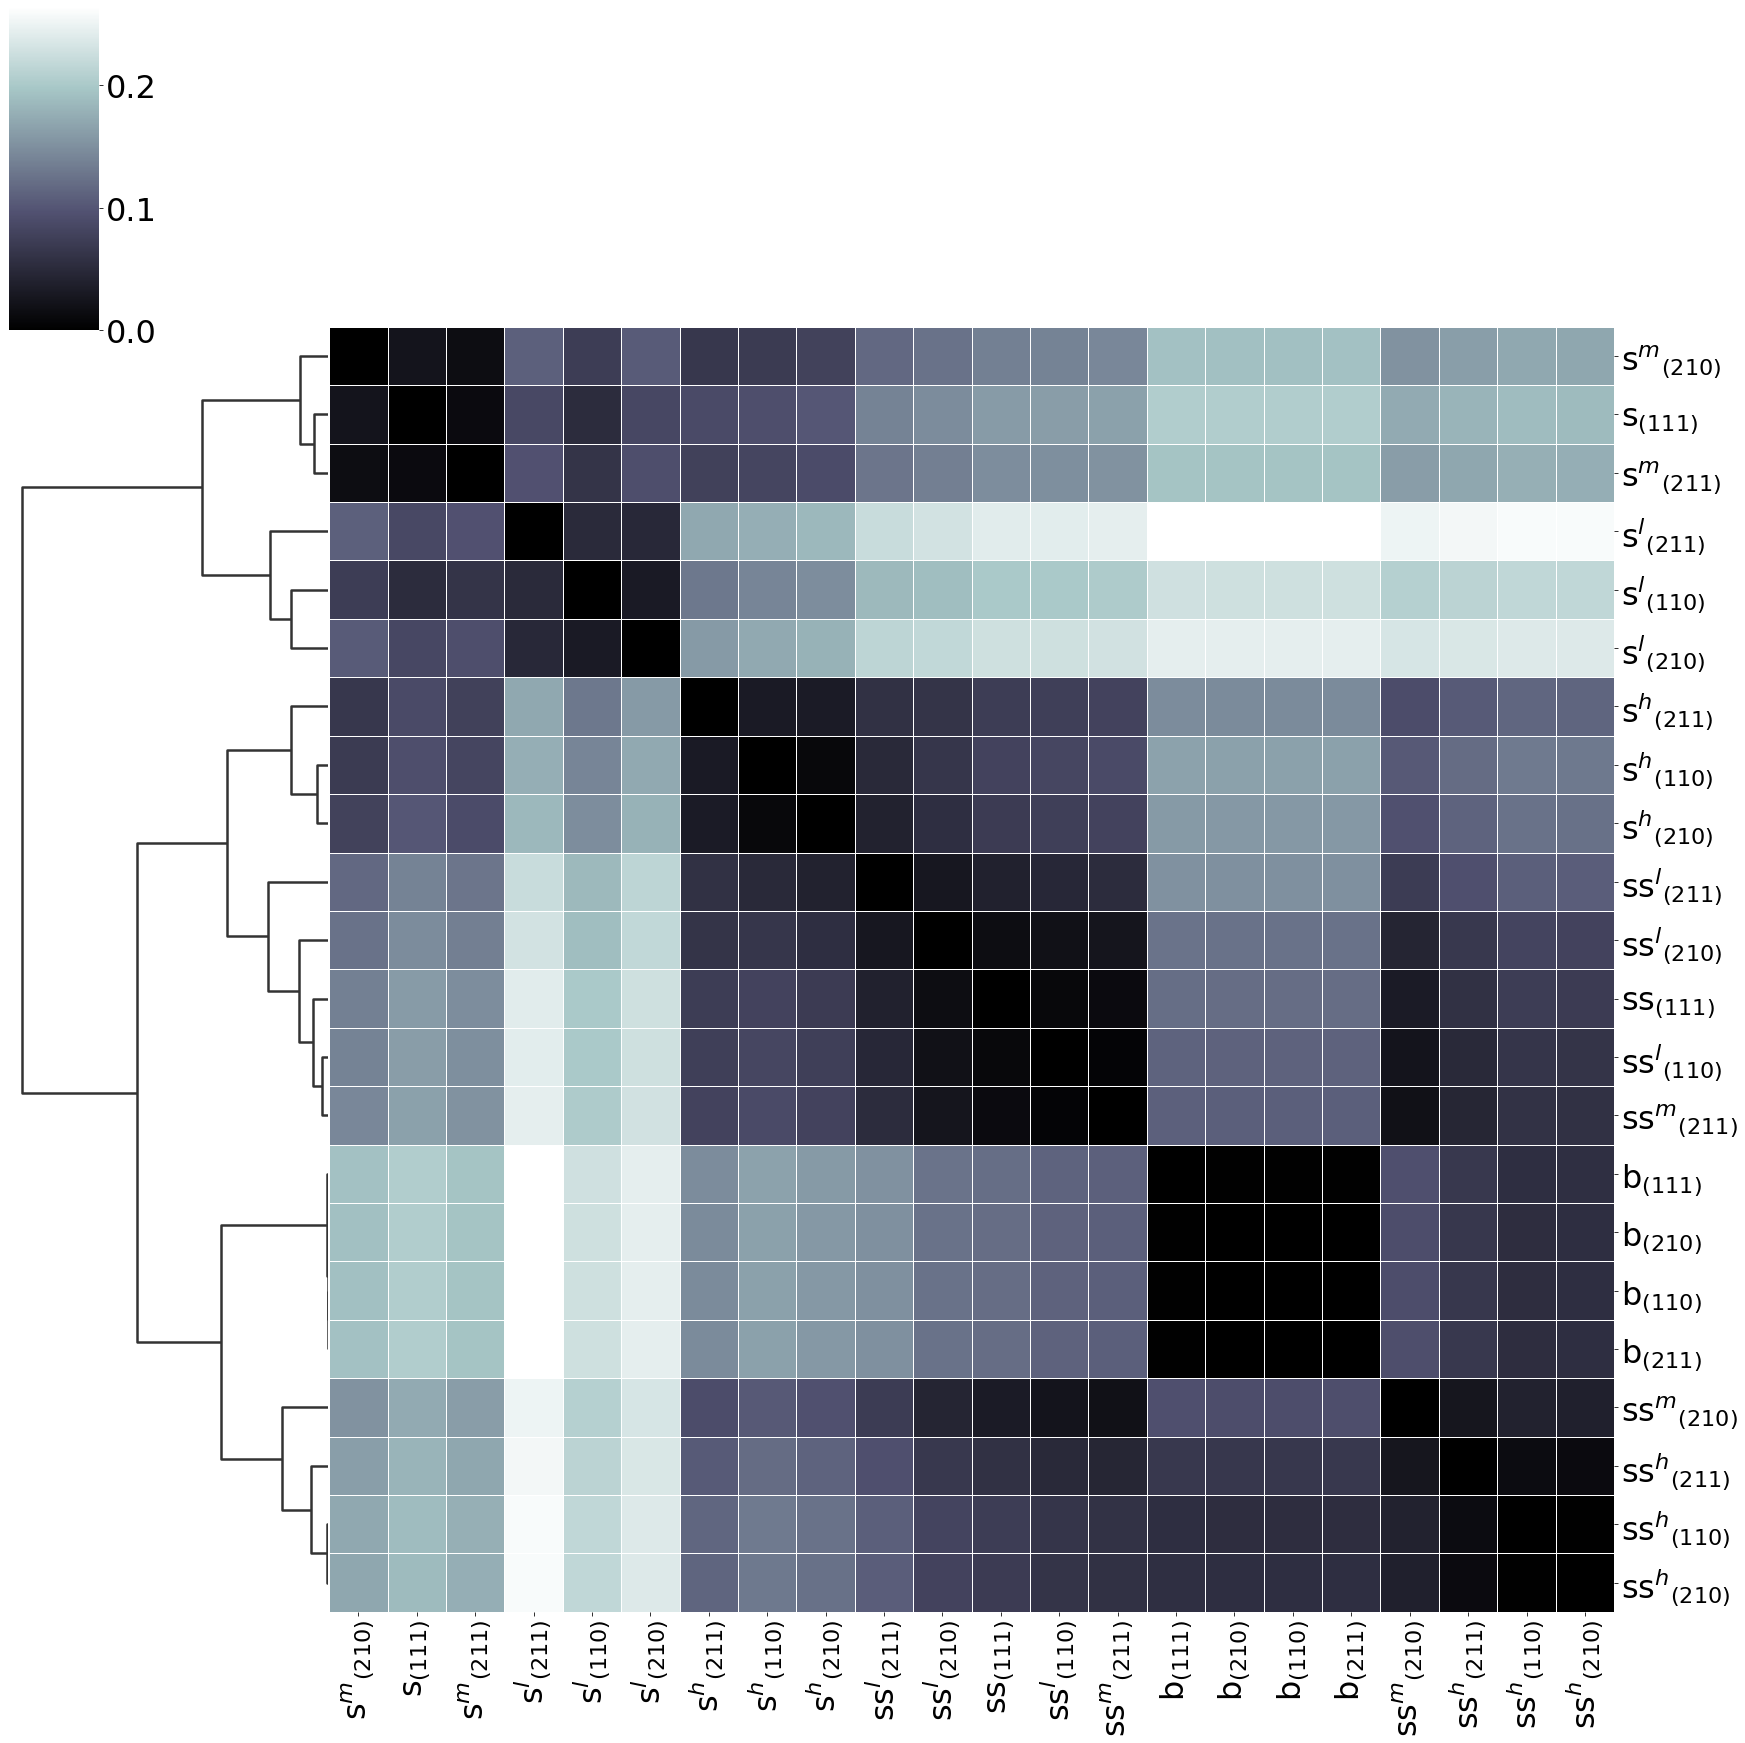

In [33]:
plt.rcParams.update({'font.size': 32})
cmap = clustermap(
    DataFrame(squareform(wholeDistances)),
    method="complete",
    cmap="bone",
    tree_kws=dict(linewidths=2.5),
    #row_colors=cr,
    #col_colors=cc,
    row_linkage=links,
    col_linkage=links,
    #linewidths=0.05,
   dendrogram_ratio=(0.2,0.2),
   linewidths=.75, 
    figsize=(25,25),
    xticklabels=dictionaryEntries, yticklabels=dictionaryEntries,
    cbar=True,
)

cmap.ax_col_dendrogram.remove()

## Applying the dictionary to the trajectories

Finally we apply the dictionary to our trajectories:

In [ ]:
for surf in [110,211,210]:
    with File(f"{surf}.hdf5", "r") as workFile:
        g=workFile[f"SOAP"]
        for key in workFile[f"SOAP"].keys():
            cls = {}
            t= classify(g[key], wholeData, SOAPdistanceNormalized, True)
            cls[f"whole"] = t.references
            cls[f"whole_d"] = t.distances
            saveXYZfromTrajGroup(
             f"whole_{surf}_T_700.xyz",
             workFile[f"Trajectories/{key}"],
             **cls,
            )